In [6]:
import sys
import os
sys.path.append('/Users/syesw/Desktop/JL-Code_Project/athena')

In [7]:
from dotenv import load_dotenv
load_dotenv()

rqdata_username = os.getenv('RQDATA_USERNAME')
rqdata_password = os.getenv('RQDATA_PASSWORD')

In [8]:
import rqdatac as rq
import pandas as pd

In [9]:
from athena import RiceQuantDataHandler, Strategy, Backtest
from athena import sort_the_factor
from athena import run_weekly, run_monthly

In [10]:
# 设置时间范围
start_date = '2015-01-01'
end_date = '2020-10-01'
#asset_list = ['000651.XSHE', '600000.XSHG']
#asset_list = rq.index_components('000300.XSHG')
rqdata = RiceQuantDataHandler(start_date, end_date)
rqdata.auth(rqdata_username,rqdata_password)

asset_list = rqdata.get_index_list('000300.XSHG')

/Users/syesw/anaconda3/envs/py310/lib/python3.10/site-packages/rqdatac/client.py:211: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)


QuotaExceeded: Quota exceeded

In [6]:
len(asset_list)

300

In [7]:
factor_data = rqdata.get_factors_from_ricequant(list=asset_list, factors=['market_cap'])

开始获取数据
数据获取完成
开始转换数据结构


In [8]:
backtest_data = rqdata.get_prices_from_ricequant(list=asset_list, fields=['open', 'high', 'low', 'close', 'volume'])

开始获取数据


QuotaExceeded: Quota exceeded

In [9]:
class SortedFactorInvestStrategy(Strategy):
    def init(self):
        print("回测准备:")
        self.first_time = True

    @run_monthly
    def next(self, i, record):
        print("----------------------")
        date = self.data.index[i]
        print(str(date) + ': ')

        current_long_positions, current_short_positions = self.broker.current_position_status()
        print("我目前持仓情况:")
        print("多头仓位:", current_long_positions)
        print("空头仓位:", current_short_positions)

        day_factors = factor_data.loc[date] # 当天的因子数据
        sorted_factor_series = sort_the_factor(day_factors, 'market_cap') # 从高到低排因子

        print('因子排名前5的股票:')
        print(sorted_factor_series[:5].index.tolist())
        short_stocks = sorted_factor_series[:5].index.tolist()
        print('因子排名后5的股票:')
        print(sorted_factor_series[-5:].index.tolist())
        long_stocks = sorted_factor_series[-5:].index.tolist()

        # 先换仓
        long_closed = short_closed = 0
        for stock in current_long_positions:
            # 对于我目前的所有多头仓位,如果不在新的list里，则平仓
            if stock not in long_stocks:
                print("关多仓:", stock)
                self.close(symbol=stock, price=record[(stock,'Close')])
                long_closed += 1
        for stock in current_short_positions:
            if stock not in short_stocks:
                print("关空仓:", stock)
                self.close(symbol=stock, price=record[(stock,'Close')])
                short_closed += 1

        total_closed = long_closed + short_closed
        if self.first_time == True:
            re_invest_size = 1 / 10 # 10只股票
        else: re_invest_size = 1 / total_closed # 关了多少，就重新开多少

        # 买进新的股票
        # 这里的换仓逻辑是，不去干涉已经开仓的股票(不加仓)
        # 对于新开仓的股票，按可分配资金的数量(1/total_closed)来开仓
        # 这样做实现了滚仓的效果
        for stock in long_stocks:
            if long_closed == 0 and self.first_time == False:
                break
            if stock not in current_long_positions:
                print("新开多仓:", stock)
                self.open(symbol=stock, size=re_invest_size, price=record[(stock,'Open')], short=False)
                long_closed -= 1
        for stock in short_stocks:
            if short_closed == 0 and self.first_time == False:
                break
            if stock not in current_short_positions:
                print("新开空仓:", stock)
                self.open(symbol=stock, size=re_invest_size, price=record[(stock,'Open')], short=True)
                short_closed -= 1
        
        self.first_time == False

        print("----------------------")


In [10]:
backtest = Backtest(SortedFactorInvestStrategy, backtest_data, commission=.001, cash=100_0000)

In [11]:
res = backtest.run()

回测准备:
----------------------
2020-01-02 00:00:00: 
我目前持仓情况:
多头仓位: []
空头仓位: []
因子排名前5的股票:
['601398.XSHG', '601939.XSHG', '601318.XSHG', '600519.XSHG', '601288.XSHG']
因子排名后5的股票:
['600039.XSHG', '002709.XSHE', '000733.XSHE', '300751.XSHE', '300442.XSHE']
新开多仓: 600039.XSHG
新开多仓: 002709.XSHE
新开多仓: 000733.XSHE
新开多仓: 300751.XSHE
新开多仓: 300442.XSHE
新开空仓: 601398.XSHG
新开空仓: 601939.XSHG
新开空仓: 601318.XSHG
新开空仓: 600519.XSHG
新开空仓: 601288.XSHG
----------------------
----------------------
2020-02-03 00:00:00: 
我目前持仓情况:
多头仓位: ['600039.XSHG', '002709.XSHE', '000733.XSHE', '300751.XSHE', '300442.XSHE']
空头仓位: ['601398.XSHG', '601939.XSHG', '601318.XSHG', '600519.XSHG', '601288.XSHG']
因子排名前5的股票:
['601398.XSHG', '601939.XSHG', '601318.XSHG', '600519.XSHG', '601288.XSHG']
因子排名后5的股票:
['600803.XSHG', '600039.XSHG', '000733.XSHE', '300751.XSHE', '300442.XSHE']
关多仓: 002709.XSHE
新开多仓: 600803.XSHG
----------------------
----------------------
2020-03-04 00:00:00: 
我目前持仓情况:
多头仓位: ['600039.XSHG', '000733.XSHE', '300

In [12]:
len(res.trades)

89

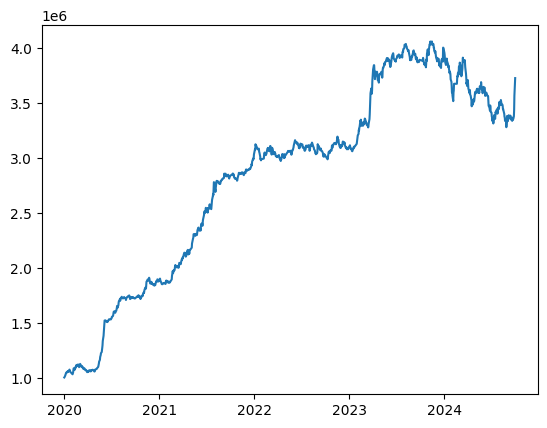

In [13]:
import matplotlib.pyplot as plt
plt.plot(res.returns)

In [15]:
trades = pd.DataFrame(res.trades)
trades

,symbol,short,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
0,002709.XSHE,False,2020-01-02,2020-02-03,5.9110,6.5259,15210.639470,9353.022210,10.402639,189.173202,1.009164e+06
1,600039.XSHG,False,2020-01-02,2020-03-04,1.9079,2.2344,52361.287227,17095.960280,17.113056,216.896160,1.026043e+06
2,000408.XSHE,False,2020-03-04,2020-04-03,5.8960,4.9753,8809.662595,-8111.056351,-15.615672,95.772485,1.017836e+06
3,600803.XSHG,False,2020-02-03,2020-05-06,8.2422,8.1625,5428.100437,-432.619605,-0.966975,89.046359,1.017314e+06
4,002709.XSHE,False,2020-04-03,2020-05-06,5.9846,7.6281,8542.243031,14039.176421,27.462153,116.282992,1.031237e+06
...,...,...,...,...,...,...,...,...,...,...,...
84,300957.XSHE,False,2024-03-08,2024-05-08,62.3010,59.7801,4035.200982,-10172.338156,-4.046323,492.621775,4.210970e+06
85,300454.XSHE,False,2024-01-08,2024-06-07,66.0002,53.0300,3748.848085,-48623.309430,-19.651759,446.226137,4.161901e+06
86,300496.XSHE,False,2024-04-08,2024-06-07,50.2641,53.4254,5035.728247,15919.447708,6.289379,522.152144,4.177298e+06
87,002841.XSHE,False,2024-03-08,2024-08-07,37.4217,29.7000,7464.387311,-57637.759502,-20.634284,501.022366,4.119159e+06


In [17]:
open_pos = pd.DataFrame(res.open_positions)
open_pos

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value,is_short
0,601398.XSHG,2020-01-02,2024-09-30,4.4650,6.18,13211.648374,-22657.976961,-38.409854,36332.033029,True
1,601939.XSHG,2020-01-02,2024-09-30,5.5276,7.93,9604.712532,-23074.361386,-43.461900,30016.647605,True
2,600519.XSHG,2020-01-02,2024-09-30,1029.2789,1748.00,41.780432,-30028.478180,-69.827634,12975.239103,True
3,600941.XSHG,2022-03-09,2024-09-30,52.4692,109.70,3561.932048,-203852.220644,-109.075038,-16960.495639,True
4,002410.XSHE,2023-11-08,2024-09-30,19.7549,13.52,17367.695546,-108285.844963,-31.561284,234811.243788,False
5,600732.XSHG,2024-05-08,2024-09-30,12.3400,10.30,20411.587395,-41639.638285,-16.531605,210239.350165,False
6,300957.XSHE,2024-06-07,2024-09-30,52.4448,62.42,5212.744383,51998.167770,19.020380,325379.504392,False
7,300142.XSHE,2024-06-07,2024-09-30,12.4100,14.72,19826.204912,45798.533347,18.614021,291841.736306,False
8,300496.XSHE,2024-08-07,2024-09-30,41.9550,52.55,6066.376402,64273.257984,25.253248,318788.079951,False
9,601288.XSHG,2024-08-07,2024-09-30,4.5700,4.80,50123.269096,-11528.351892,-5.032823,217534.987878,True
